# Complete System Analysis - Acoustic Manufacturing
## Including All Custom Parts and COTS Components

In [26]:
import sys
import os

# Add the project root to Python path
if 'notebooks' in os.getcwd():
    project_root = os.path.dirname(os.getcwd())
else:
    project_root = os.getcwd()

if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"Current directory: {os.getcwd()}")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import our modules
from models.complete_bom_generator import generate_complete_bom, generate_cost_summary
from models.custom_parts_library import custom_parts_database, cots_additions_database

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100

print("Imports successful!")

Project root: /Users/jmarwell/Desktop/Projects/drip/acoustic-sysml-v2
Current directory: /Users/jmarwell/Desktop/Projects/drip/acoustic-sysml-v2/notebooks
Imports successful!


## 1. Complete Cost Breakdown Analysis

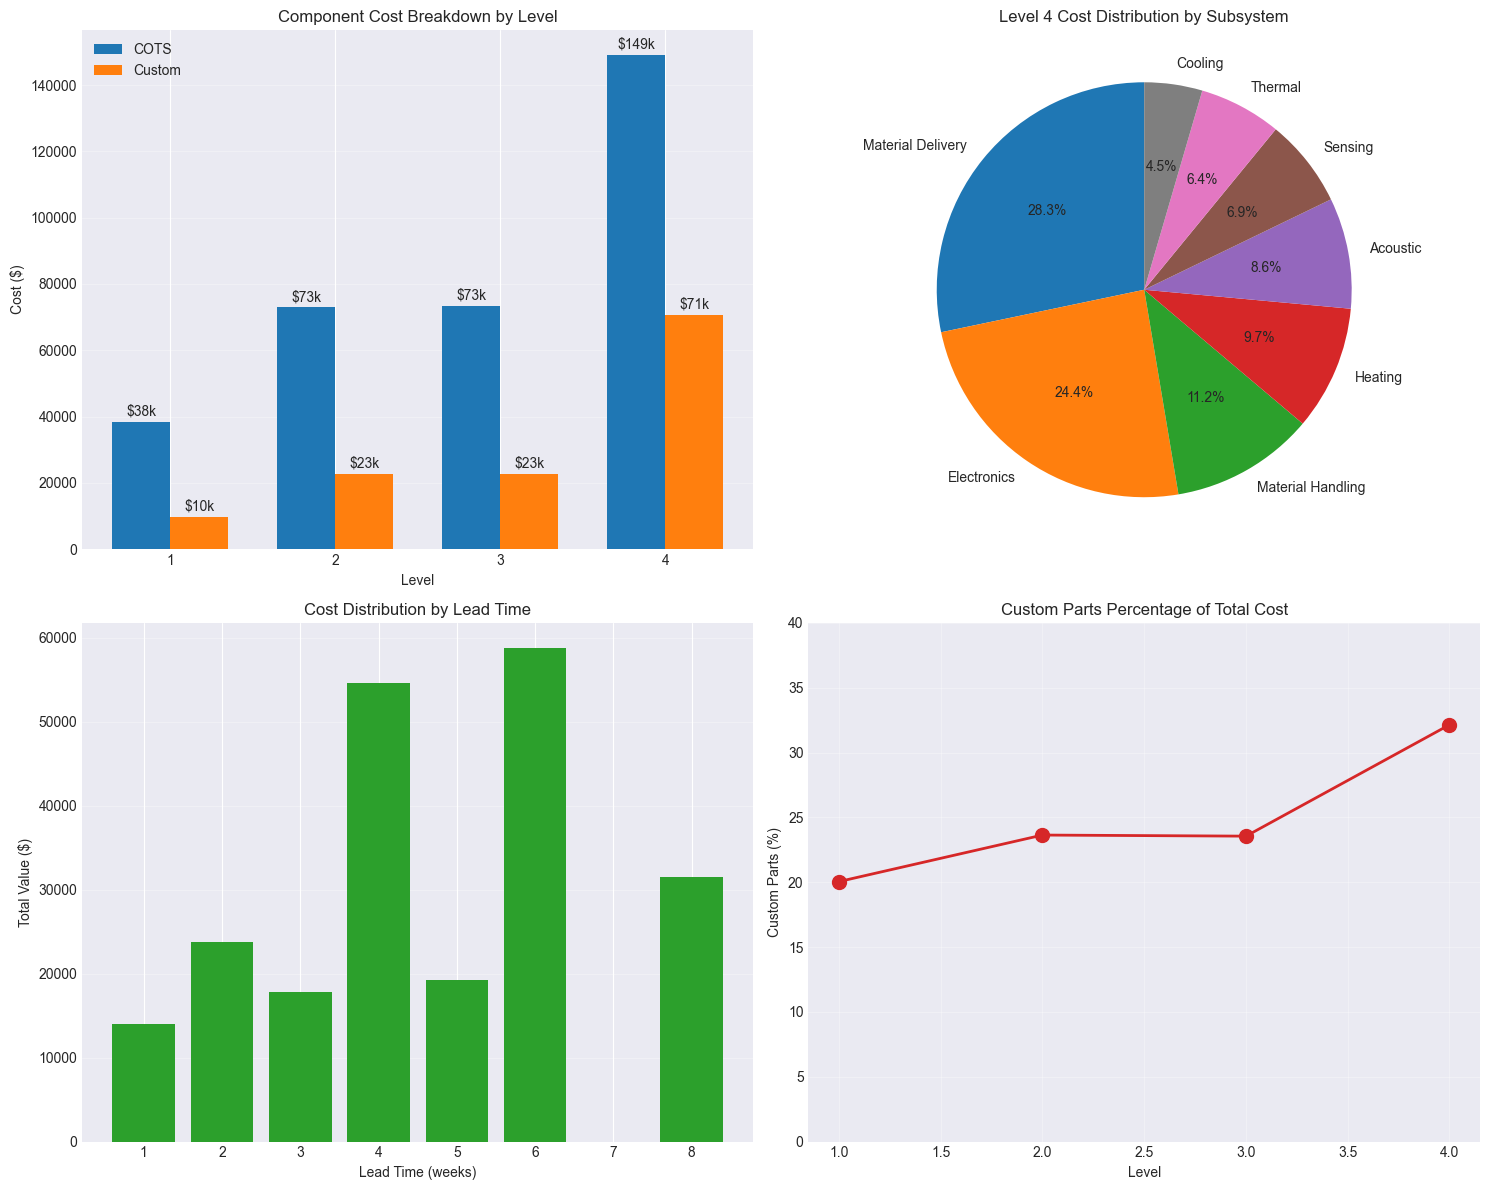


KEY METRICS:
Level 1 → Level 4 Cost Increase: 358.1%
Custom Parts at Level 4: 32.1% of total
Maximum Lead Time: 8 weeks


In [27]:
# Generate complete cost analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Total cost progression
levels = [1, 2, 3, 4]
total_costs = []
cots_costs = []
custom_costs = []

for level in levels:
    bom = generate_complete_bom(level)
    total_costs.append(bom['Extended Cost'].sum())
    cots_costs.append(bom[bom['Category'] == 'COTS']['Extended Cost'].sum())
    custom_costs.append(bom[bom['Category'] == 'Custom']['Extended Cost'].sum())

x = np.arange(len(levels))
width = 0.35

bars1 = ax1.bar(x - width/2, cots_costs, width, label='COTS', color='#1f77b4')
bars2 = ax1.bar(x + width/2, custom_costs, width, label='Custom', color='#ff7f0e')

ax1.set_xlabel('Level')
ax1.set_ylabel('Cost ($)')
ax1.set_title('Component Cost Breakdown by Level')
ax1.set_xticks(x)
ax1.set_xticklabels(levels)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1000,
                f'${height/1000:.0f}k', ha='center', va='bottom')

# 2. Cost distribution pie chart for Level 4
_, sub_summary = generate_cost_summary(4)
ax2.pie(sub_summary['Total Cost'][:8], labels=sub_summary['Subsystem'][:8], 
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Level 4 Cost Distribution by Subsystem')

# 3. Lead time analysis
bom4 = generate_complete_bom(4)
lead_times = bom4.groupby('Lead Time (weeks)')['Extended Cost'].sum()
ax3.bar(lead_times.index, lead_times.values, color='#2ca02c')
ax3.set_xlabel('Lead Time (weeks)')
ax3.set_ylabel('Total Value ($)')
ax3.set_title('Cost Distribution by Lead Time')
ax3.grid(axis='y', alpha=0.3)

# 4. Custom vs COTS ratio
ratios = [custom_costs[i]/total_costs[i]*100 for i in range(4)]
ax4.plot(levels, ratios, 'o-', linewidth=2, markersize=10, color='#d62728')
ax4.set_xlabel('Level')
ax4.set_ylabel('Custom Parts (%)')
ax4.set_title('Custom Parts Percentage of Total Cost')
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 40)

plt.tight_layout()
plt.show()

# Print key metrics
print("\nKEY METRICS:")
print(f"Level 1 → Level 4 Cost Increase: {(total_costs[3]/total_costs[0] - 1)*100:.1f}%")
print(f"Custom Parts at Level 4: {custom_costs[3]/total_costs[3]*100:.1f}% of total")
print(f"Maximum Lead Time: {bom4['Lead Time (weeks)'].max()} weeks")

## 2. Subsystem Architecture Visualization

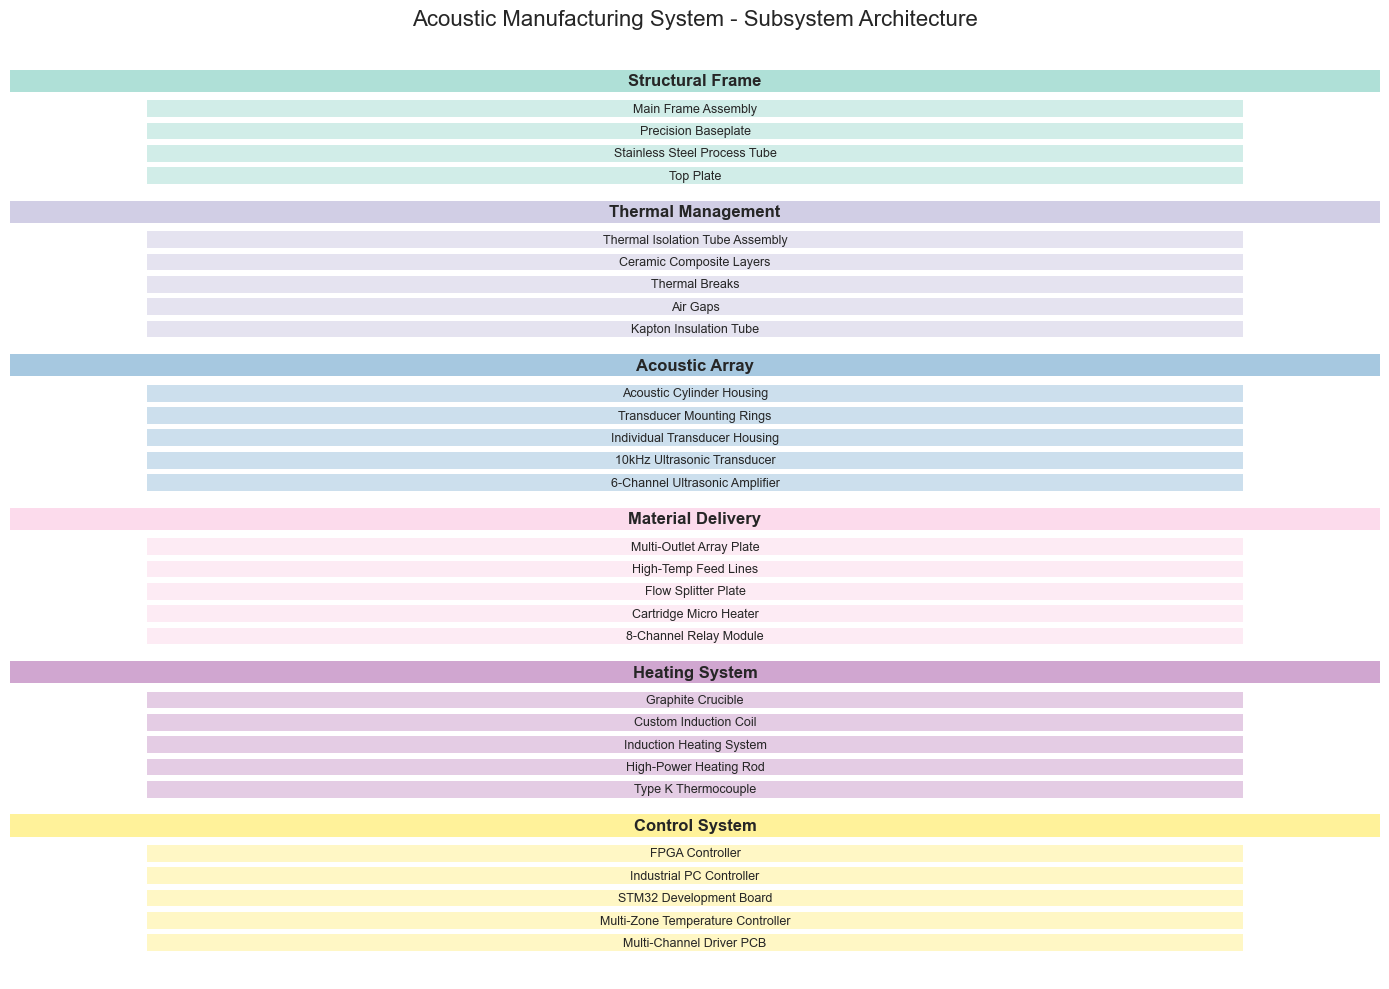

In [28]:
# Create subsystem breakdown
subsystems = {
    'Structural Frame': ['Main Frame Assembly', 'Precision Baseplate', 'Stainless Steel Process Tube', 'Top Plate'],
    'Thermal Management': ['Thermal Isolation Tube Assembly', 'Ceramic Composite Layers', 'Thermal Breaks', 
                          'Air Gaps', 'Kapton Insulation Tube', 'Recirculating Water Chiller'],
    'Acoustic Array': ['Acoustic Cylinder Housing', 'Transducer Mounting Rings', 'Individual Transducer Housing',
                      '10kHz Ultrasonic Transducer', '6-Channel Ultrasonic Amplifier', 'Linear Assembly Rails'],
    'Material Delivery': ['Multi-Outlet Array Plate', 'High-Temp Feed Lines', 'Flow Splitter Plate',
                         'Cartridge Micro Heater', '8-Channel Relay Module'],
    'Heating System': ['Graphite Crucible', 'Custom Induction Coil', 'Induction Heating System',
                      'High-Power Heating Rod', 'Type K Thermocouple'],
    'Control System': ['FPGA Controller', 'Industrial PC Controller', 'STM32 Development Board',
                      'Multi-Zone Temperature Controller', 'Multi-Channel Driver PCB']
}

# Create hierarchical visualization
fig, ax = plt.subplots(figsize=(14, 10))

y_pos = 0
colors = plt.cm.Set3(np.linspace(0, 1, len(subsystems)))

for (subsystem, components), color in zip(subsystems.items(), colors):
    # Draw subsystem header
    ax.barh(y_pos, 100, height=0.8, color=color, alpha=0.7)
    ax.text(50, y_pos, subsystem, ha='center', va='center', fontweight='bold', fontsize=12)
    y_pos -= 1
    
    # Draw components
    for comp in components[:5]:  # Limit to 5 components per subsystem for clarity
        ax.barh(y_pos, 80, height=0.6, left=10, color=color, alpha=0.4)
        ax.text(50, y_pos, comp, ha='center', va='center', fontsize=9)
        y_pos -= 0.8
    
    y_pos -= 0.5

ax.set_xlim(0, 100)
ax.set_ylim(y_pos, 1)
ax.axis('off')
ax.set_title('Acoustic Manufacturing System - Subsystem Architecture', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

## 3. Critical Path Analysis

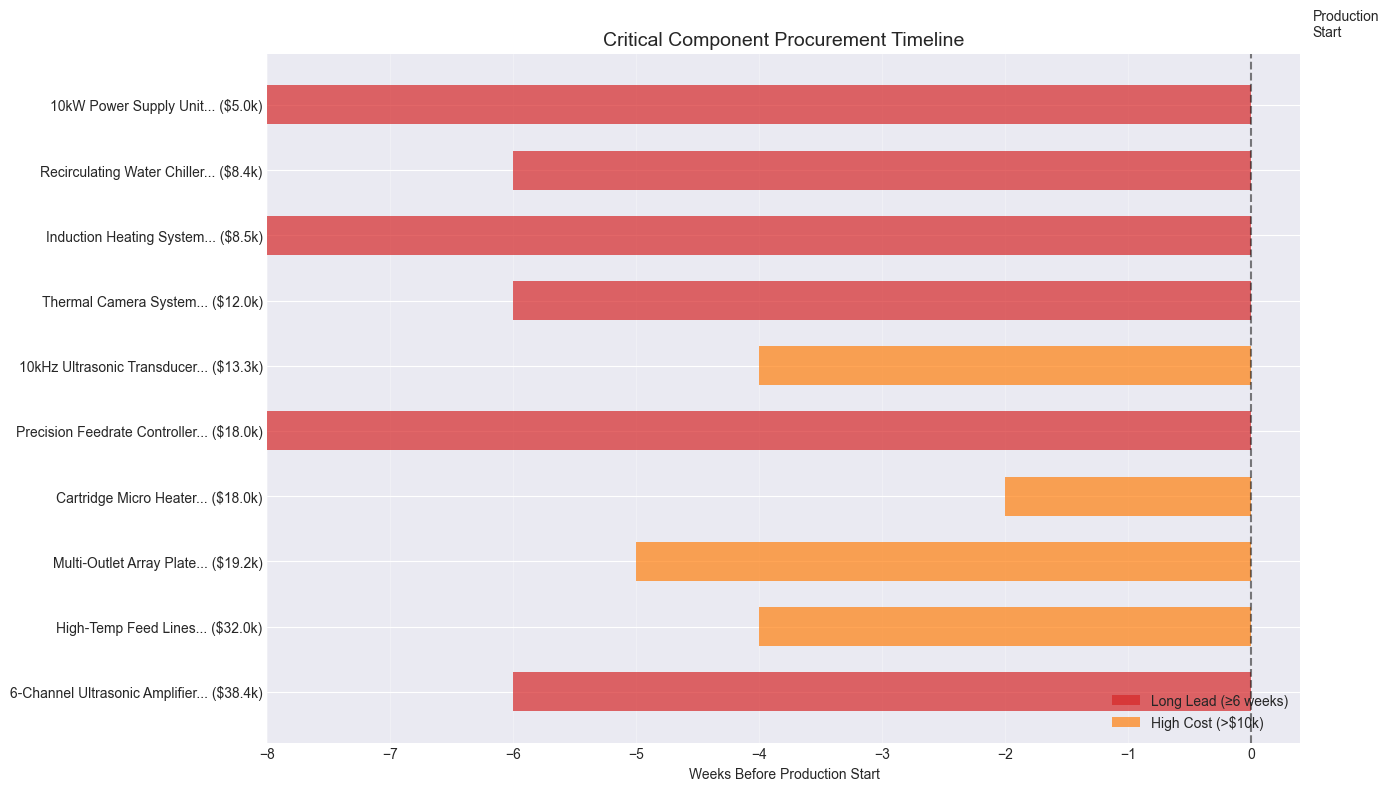


CRITICAL PATH SUMMARY:
Items requiring ≥6 weeks: 6
Items costing >$10k: 7
Total critical items value: $172,820.00


In [29]:
# Identify critical path items
bom4 = generate_complete_bom(4)
critical_items = bom4[(bom4['Lead Time (weeks)'] >= 6) | (bom4['Extended Cost'] > 10000)]
critical_items = critical_items.sort_values('Extended Cost', ascending=False)

# Create Gantt-style procurement timeline
fig, ax = plt.subplots(figsize=(14, 8))

y_labels = []
y_pos = []
colors = []

for i, (_, row) in enumerate(critical_items.head(15).iterrows()):
    start = -row['Lead Time (weeks)']
    duration = row['Lead Time (weeks)']
    
    color = '#d62728' if row['Lead Time (weeks)'] >= 6 else '#ff7f0e'
    ax.barh(i, duration, left=start, height=0.6, color=color, alpha=0.7)
    
    y_labels.append(f"{row['Component'][:30]}... (${row['Extended Cost']/1000:.1f}k)")
    y_pos.append(i)

ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.set_xlabel('Weeks Before Production Start')
ax.set_title('Critical Component Procurement Timeline', fontsize=14)
ax.grid(axis='x', alpha=0.3)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.text(0.5, len(y_pos), 'Production\nStart', ha='left', va='bottom')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d62728', alpha=0.7, label='Long Lead (≥6 weeks)'),
    Patch(facecolor='#ff7f0e', alpha=0.7, label='High Cost (>$10k)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("\nCRITICAL PATH SUMMARY:")
print(f"Items requiring ≥6 weeks: {len(bom4[bom4['Lead Time (weeks)'] >= 6])}")
print(f"Items costing >$10k: {len(bom4[bom4['Extended Cost'] > 10000])}")
print(f"Total critical items value: ${critical_items['Extended Cost'].sum():,.2f}")

# Display complete BOM for Level 4
bom4 = generate_complete_bom(4)

# Sort by Extended Cost (descending) before formatting
bom4_sorted = bom4.sort_values('Extended Cost', ascending=False)

# Format for display
display_bom = bom4_sorted.copy()
display_bom['Unit Cost'] = display_bom['Unit Cost'].apply(lambda x: f"${x:,.2f}")
display_bom['Extended Cost'] = display_bom['Extended Cost'].apply(lambda x: f"${x:,.2f}")

print("COMPLETE BILL OF MATERIALS - LEVEL 4")
print("="*100)
print(f"\nTotal Items: {len(bom4)}")
print(f"Total Quantity: {bom4['Quantity'].sum()}")
print(f"Total Cost: ${bom4['Extended Cost'].sum():,.2f}")
print("\nTop 20 Components by Cost:")
print(display_bom.head(20)[['Component', 'Quantity', 'Unit Cost', 'Extended Cost', 'Lead Time (weeks)']].to_string(index=False))

In [30]:
# Display complete BOM for Level 4
bom4 = generate_complete_bom(4)

# Sort by Extended Cost (descending) BEFORE formatting
bom4_sorted = bom4.sort_values('Extended Cost', ascending=False)

# Format for display
display_bom = bom4_sorted.copy()
display_bom['Unit Cost'] = display_bom['Unit Cost'].apply(lambda x: f"${x:,.2f}")
display_bom['Extended Cost_formatted'] = display_bom['Extended Cost'].apply(lambda x: f"${x:,.2f}")

print("COMPLETE BILL OF MATERIALS - LEVEL 4")
print("="*100)
print(f"\nTotal Items: {len(bom4)}")
print(f"Total Quantity: {bom4['Quantity'].sum()}")
print(f"Total Cost: ${bom4['Extended Cost'].sum():,.2f}")
print("\nTop 20 Components by Cost:")

# Select top 20 and rename column for display
top20 = display_bom.head(20)[['Component', 'Quantity', 'Unit Cost', 'Extended Cost_formatted', 'Lead Time (weeks)']].copy()
top20.columns = ['Component', 'Quantity', 'Unit Cost', 'Extended Cost', 'Lead Time (weeks)']
print(top20.to_string(index=False))

COMPLETE BILL OF MATERIALS - LEVEL 4

Total Items: 34
Total Quantity: 1650
Total Cost: $219,684.00

Top 20 Components by Cost:
                        Component  Quantity  Unit Cost Extended Cost  Lead Time (weeks)
   6-Channel Ultrasonic Amplifier        12  $3,200.00    $38,400.00                  6
             High-Temp Feed Lines       400     $80.00    $32,000.00                  4
         Multi-Outlet Array Plate        16  $1,200.00    $19,200.00                  5
    Precision Feedrate Controller         4  $4,500.00    $18,000.00                  8
           Cartridge Micro Heater       400     $45.00    $18,000.00                  2
      10kHz Ultrasonic Transducer        72    $185.00    $13,320.00                  4
            Thermal Camera System         1 $12,000.00    $12,000.00                  6
           8-Channel Relay Module        80    $120.00     $9,600.00                  1
         Induction Heating System         1  $8,500.00     $8,500.00             